Reading trained model from model.pkl
Epoch: #1, MSE: 0.002377, CE: 0.051199, Accuracy: 97.32%
Epoch: #2, MSE: 0.002188, CE: 0.047252, Accuracy: 97.32%
Epoch: #3, MSE: 0.002025, CE: 0.043846, Accuracy: 97.33%
Epoch: #4, MSE: 0.001881, CE: 0.040853, Accuracy: 97.37%
Epoch: #5, MSE: 0.001751, CE: 0.038183, Accuracy: 97.40%
Epoch: #6, MSE: 0.001631, CE: 0.035781, Accuracy: 97.39%
Epoch: #7, MSE: 0.001521, CE: 0.033613, Accuracy: 97.40%
Epoch: #8, MSE: 0.001421, CE: 0.031658, Accuracy: 97.39%
Epoch: #9, MSE: 0.001330, CE: 0.029896, Accuracy: 97.41%
Epoch: #10, MSE: 0.001247, CE: 0.028307, Accuracy: 97.41%
Times Used 720.05 S


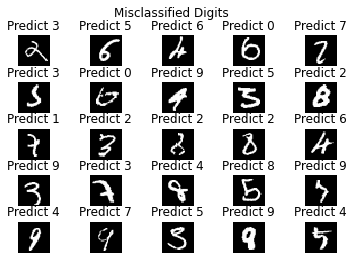

In [1]:
"""
Handwritten Digit Classification using Multi-Layer Perception (fully connected NN) and Numpy
MNIST
"""
import numpy as np
import pickle
from progress.bar import IncrementalBar
import matplotlib.pyplot as plt
import time

class Activate:
    @staticmethod
    def apply_activation(r, activation=None):
        if activation is None:
            return r
        elif activation == 'relu':
            return np.maximum(r, 0)
        elif activation == 'tanh':
            return np.tanh(r)
        elif activation == 'sigmoid':
            return 1 / (1 + np.exp(-r))
        elif activation == 'softmax':
            r = r - np.max(r, axis=-1, keepdims=True)  # numerically stable softmax
            exp_r = np.exp(r)
            return exp_r / np.sum(exp_r, axis=-1, keepdims=True)
        return r
    @staticmethod
    def apply_activation_derivative(output, activation=None):
        """ Calculate the derivative of activation function """
        if activation is None: # No activation function, derivative is 1
            return np.ones_like(output)
        elif activation == 'relu':
            grad = np.array(output, copy=True)
            grad[output > 0] = 1.
            grad[output <= 0] = 0.
            return grad
        elif activation == 'tanh':
            return 1 - output ** 2
        elif activation == 'sigmoid':
            return output * (1 - output)
        return output

class DenseLayer:
    """ A Fully Connected Layer """
    def __init__(self, n_input, n_output, activation=None, weights=None, bias=None):
        """
        :param int n_input: Number of input nodes/neurons of previous layer
        :param int n_output: Number of output nodes/neurons of this layer
        :param str activation: Type of activation function
        :param weights : Weight of input connections
        :param bias : Bias of input connections
        """
        self.weights = weights if weights is not None else np.random.randn(n_input, n_output) / np.sqrt(n_input) # Xavier initialization
        self.bias = bias if bias is not None else np.random.rand(n_output) * 0.2
        self.weights_update = np.zeros_like(self.weights)  # weights_new = weights_old + weights_update
        self.bias_update = np.zeros_like(self.bias)  # bias_new = bias_old + bias_update
        self.activation = activation  # relu tanh or sigmoid
        self.output = None  # Output/activation value of this layer
        self.error = None  # Error or loss gradient of output, error = y - output
        self.delta = None  # Delta of X@W + b, delta = error*activation_derivative(output)
        self.error_input = None  # Error or loss gradient of input, previous_layer.error = layer.error_input
    def activate(self, X):
        """ Forward propagation """
        r = np.dot(X, self.weights) + self.bias # X@W + b
        self.output = Activate.apply_activation(r, self.activation)
        return self.output
    def back_propagation(self, X, error, learning_rate):
        assert error.shape == self.output.shape
        self.error = error
        if self.activation == 'softmax':  # output layer
            self.delta = self.error
        else:
            self.delta = self.error*Activate.apply_activation_derivative(self.output, self.activation)
        self.error_input = np.dot(self.weights, self.delta)  # Chain Rule
        X = np.atleast_2d(X)  # X is the output of previous layer
        self.weights_update -= self.delta * X.T * learning_rate  # gradient descent
        self.bias_update -= self.delta * learning_rate

class NeuralNetwork:
    def __init__(self):
        self._layers = []
        self._mses = []  # Mean Square Errors on training set
        self._ces = []  # Cross Entropy on training set
        self._accuracy = []  # Accuracy on test set
    def add_layer(self, layer):
        self._layers.append(layer)
    def feed_forward(self, X):
        """ Forward propagation """
        for layer in self._layers:
            X = layer.activate(X)
        return X
    def backpropagation(self, X, y, learning_rate):
        output = self.feed_forward(X)
        for i in reversed(range(len(self._layers))): # propagate the error backward
            layer = self._layers[i]
            X_input = X if i == 0 else self._layers[i - 1].output
            if layer == self._layers[-1]: # output layer
                error = output - y  # softmax classification with categorical cross-entropy loss
            else: # hidden layer
                error = self._layers[i + 1].error_input
            layer.back_propagation(X_input, error, learning_rate)
    def train(self, X_train, X_test, y_train, y_test, learning_rate, batch_size, max_epochs):
        """ Mini-Batch Gradient Descent """
        y_onehot = np.zeros((y_train.shape[0], 10))  # one-hot coding
        y_onehot[np.arange(y_train.shape[0]), y_train] = 1
        for i in range(1, max_epochs+1):
            bar = IncrementalBar('Processing', max=len(X_train), suffix='%(index)d/%(max)d %(elapsed)ds')
            for j in range(len(X_train)):
                self.backpropagation(X_train[j], y_onehot[j], learning_rate)  # one sample each train
                if j % batch_size == batch_size - 1:  # averaging updates over batch
                    bar.next(batch_size)
                    for k in range(len(self._layers)):
                        layer = self._layers[k]
                        if type(layer) == DenseLayer:
                            layer.weights += layer.weights_update / batch_size
                            layer.bias += layer.bias_update / batch_size
                            layer.weights_update = np.zeros_like(layer.weights)  # restart averaging over batch
                            layer.bias_update = np.zeros_like(layer.bias)
            bar.finish()
            y_predict = self.predict(X_train)
            mse = np.mean(np.square(y_predict - y_onehot))
            self._mses.append(mse)
            ce = np.mean(-np.sum(y_onehot * np.log(y_predict), axis = 1))
            self._ces.append(ce)
            accuracy = self.accuracy(self.predict(X_test), y_test.flatten())
            self._accuracy.append(accuracy)
            print('Epoch: #%s, MSE: %f, CE: %f, Accuracy: %.2f%%' %(i, mse, ce, accuracy * 100))
            self.save('model.pkl')  # saving checkpoint for each epoch
            learning_rate = learning_rate * 0.95  # decay learning rate
    def accuracy(self, y_predict, y_test):
        y_predict = np.argmax(y_predict, axis=1) #  find the index/class of highest probability
        return np.sum(y_predict == y_test) / len(y_test)
    def predict(self, X_predict):
        y_predict = self.feed_forward(X_predict) #  probability distribution of y_predict
        return y_predict
    def save(self, file_name):  # saving trained model to disk
        f = open(file_name, 'wb')
        pickle.dump(self, f)
        f.close()
    def read(self, file_name):  # reading trained model from disk
        try:
            print('Reading trained model from %s' %(file_name))
            f= open(file_name, 'rb')
            tmp_dict = pickle.load(f)
            f.close()
            for i in range(len(self.__dict__['_layers'])):
                if type(self.__dict__['_layers'][i]) != type(tmp_dict.__dict__['_layers'][i]):
                    print('Different structure found in %s' %(file_name))
                    return
            self.__dict__.clear()
            self.__dict__.update(tmp_dict.__dict__)
        except IOError: print('File %s is not accessible' %(file_name))

f = np.load('mnist.npz')
X_train, y_train = f['x_train'], f['y_train']
X_test, y_test = f['x_test'], f['y_test']
f.close()

X_train = X_train.reshape(X_train.shape[0],784).astype("float32") / 255
X_test = X_test.reshape(X_test.shape[0],784).astype("float32") / 255

nn = NeuralNetwork()  # 3 layers, 784 inputs, 10 outputs
nn.add_layer(DenseLayer(784, 50, 'sigmoid'))  # hidden layer 1, 784 input => 50 output
nn.add_layer(DenseLayer(50, 50, 'sigmoid'))  # hidden layer 2, 50 => 50
nn.add_layer(DenseLayer(50, 10, 'softmax'))  # output layer, 50 => 10

nn.read('model.pkl')  # reading checkpoints if model.pkl exists

batch_size = 10
learning_rate = 0.02 * np.sqrt(batch_size)
time_start = time.time()
nn.train(X_train, X_test, y_train, y_test, learning_rate, batch_size, max_epochs=10)
time_end = time.time()
print("Times Used %.2f S"%(time_end - time_start))

def plot_misprediction(model, X_test, y_test):
    n = 1
    for i in range(len(X_test)):
        y_predict = np.argmax(model.feed_forward(X_test[i]))
        if y_predict != y_test[i]:
            plt.subplot(5, 5, n)
            plt.imshow(X_test[i].reshape(28,28), cmap='gray', interpolation='none')
            plt.title("Predict {}".format(y_predict))
            plt.axis('off')
            n += 1
        if n > 25:
            break
    plt.subplots_adjust(wspace=0.5,hspace=0.5)
    plt.suptitle('Misclassified Digits')
    plt.savefig("MisclassifiedDigits.png", format="png", dpi=150)

plot_misprediction(nn, X_test, y_test)  # visal evaluation